# Vector data
This notebook demonstrates core vector data management and visualization workflows in Python using GeoPandas, Shapely and PyProj. Focus: IO, CRS/reprojection, simple cleaning, indexing, plotting and exporting.

In [186]:
# Cell 1: imports and environment check
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
import shapely.geometry as geom
import sys
print('geopandas', gpd.__version__)
print('pyproj', pyproj.__version__)
print('python', sys.version.splitlines()[0])

geopandas 1.0.1
pyproj 3.7.1
python 3.13.3 | packaged by conda-forge | (main, Apr 10 2025, 22:22:14) [Clang 18.1.8 ]


## Read vector data
Use `gpd.read_file` to read shapefiles, GeoPackage or GeoJSON.

In [187]:
# Use example file from repo-level data folder
path = 'data/berlin-neighbourhoods/berlin-neighbourhoods.geojson'
gdf = gpd.read_file(path)
gdf.head()

,neighbourh,neighbou_1,median_pri,geometry
0,Blankenfelde/Niederschönhausen,Pankow,37.5,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52..."
1,Helmholtzplatz,Pankow,58.0,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52..."
2,Wiesbadener Straße,Charlottenburg-Wilm.,50.0,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52..."
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,99.0,"MULTIPOLYGON (((13.70973 52.3963, 13.70926 52...."
4,Müggelheim,Treptow - Köpenick,25.0,"MULTIPOLYGON (((13.73762 52.4085, 13.73773 52...."


## Inspect CRS and reprojecting
Always check CRS before spatial operations. Use `to_crs` to reproject.

In [188]:
# Show original CRS and bounds
print('original crs:', gdf.crs)
print('bounds:', gdf.total_bounds)
# Reproject to WGS84 (EPSG:4326) if needed
gdf_wgs = gdf.to_crs(epsg=4326)
print('reprojected crs:', gdf_wgs.crs)
gdf_wgs.head()

original crs: EPSG:4326
bounds: [13.088354 52.338239 13.761131 52.675509]
reprojected crs: EPSG:4326


,neighbourh,neighbou_1,median_pri,geometry
0,Blankenfelde/Niederschönhausen,Pankow,37.5,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52..."
1,Helmholtzplatz,Pankow,58.0,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52..."
2,Wiesbadener Straße,Charlottenburg-Wilm.,50.0,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52..."
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,99.0,"MULTIPOLYGON (((13.70973 52.3963, 13.70926 52...."
4,Müggelheim,Treptow - Köpenick,25.0,"MULTIPOLYGON (((13.73762 52.4085, 13.73773 52...."


## Simple cleaning and spatial indexing
Drop invalid geometries, create a spatial index and show quick stats.

In [189]:
# drop rows with missing geometry
gdf = gdf[~gdf.geometry.is_empty]
gdf = gdf[gdf.geometry.notnull()]
# remove invalid geometries using buffer(0) trick if needed
gdf['is_valid'] = gdf.is_valid
if not gdf['is_valid'].all():
    gdf['geometry'] = gdf['geometry'].buffer(0)
    gdf['is_valid'] = gdf.is_valid
# spatial index exists on-the-fly in geopandas when needed (uses rtree/pygeos when installed)
print('rows:', len(gdf))

rows: 138


## Visualization (quick plots)
Use `plot` for quick maps and `contextily` for basemaps (optional). Keep plots simple for Classroom use.

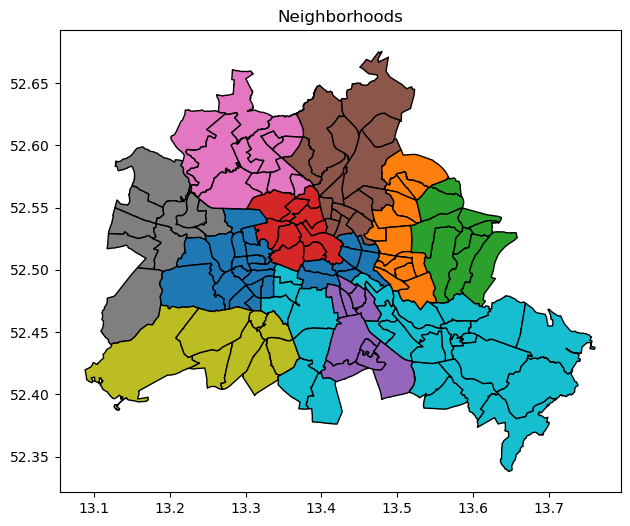

In [190]:
# Simple plot
ax = gdf.plot(figsize=(8,6), column=gdf.columns[1] if len(gdf.columns)>1 else None, legend=False, edgecolor='k')
ax.set_title('Neighborhoods')
plt.show()

## Short notes on coordinate systems
- CRS tells how coordinates map to positions on Earth.
- Use EPSG codes (`EPSG:4326` for lat/lon WGS84; `EPSG:3857` for Web Mercator).
- Prefer storing data in a consistent CRS; reproject for analysis or visualization as needed.
- Use `pyproj.CRS` for inspect and build transforms when needed.

In [191]:
# show pyproj usage example
from pyproj import CRS, Transformer
crs1 = CRS.from_epsg(4326)
crs2 = CRS.from_epsg(3857)
transformer = Transformer.from_crs(crs1, crs2, always_xy=True)
print('transformer example:', transformer.transform(13.405, 52.52))  # lon, lat for Berlin

transformer example: (1492237.774083832, 6894699.801282424)


## Quick exercise
Reproject the GeoDataFrame to EPSG:3857, compute area in square meters (use `.area` after reprojection), and save results to a CSV.

In [192]:
# student solution example
gdf_m = gdf.to_crs(epsg=3857)
gdf_m['area_m2'] = gdf_m.geometry.area
gdf_m[['area_m2']].head()

,area_m2
0,5.325793e+07
1,1.928130e+06
2,3.705703e+06
3,4.588417e+07
4,5.954863e+07


## Advanced case study: Texas ZIP codes + listings
This section extends the tutorial with a coherent GeoPandas-only workflow using Texas ZIP code polygons and listing points. We'll cover validity, CRS for metrics, spatial joins, dissolves, overlays, plotting, and exports.


In [193]:
# Read Texas ZIP codes and listings; construct point GeoDataFrame
import geopandas as gpd
import pandas as pd
from pathlib import Path

base = Path('/Users/rschifan/Desktop/teaching/data/texas')
zip_path = base / 'Zipcodes.geojson'
listings_path = base / 'listings.csv.gz'

# Read polygons (assume GeoJSON is in WGS84 unless metadata differs)
tx_zip = gpd.read_file(zip_path)
if tx_zip.crs is None:
    tx_zip = tx_zip.set_crs(4326)

# Read listings and create point GeoDataFrame
df = pd.read_csv(listings_path)
lat_col = next(c for c in df.columns if c.lower() in ['latitude','lat'])
lon_col = next(c for c in df.columns if c.lower() in ['longitude','lon','lng'])

# Drop rows without coordinates and build points in WGS84
tx_listings = gpd.GeoDataFrame(
    df.dropna(subset=[lat_col, lon_col]).copy(),
    geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
    crs='EPSG:4326'
)

print('TX zipcodes bounds:', tx_zip.to_crs(4326).total_bounds)
print('Listings bounds:', tx_listings.total_bounds)
print(f'Rows — ZIPs: {len(tx_zip):,}, listings: {len(tx_listings):,}')


TX zipcodes bounds: [-98.5898091   29.6696728  -97.18406706  31.03780477]
Listings bounds: [-98.0073241   30.13051636  -5.09368239  43.21499077]
Rows — ZIPs: 80, listings: 5,835


### Geometry quality and type hygiene
Validate geometries, fix invalids, explode multipart shapes, drop empties. We'll remove tiny slivers after projecting to a metric CRS.


In [194]:
# Validate, fix invalid, explode, drop empties
import shapely

# Track original count
print('ZIPs before:', len(tx_zip))

# Ensure polygon-only and non-empty
tx_zip = tx_zip[tx_zip.geometry.notnull()].copy()

# Make valid if needed (Shapely 2 has make_valid)
if hasattr(shapely, 'make_valid'):
    tx_zip['geometry'] = shapely.make_valid(tx_zip.geometry)
else:
    tx_zip['geometry'] = tx_zip.buffer(0)

# Drop now-empty or still-invalid
tx_zip = tx_zip[~tx_zip.geometry.is_empty]
invalid_mask = ~tx_zip.is_valid
if invalid_mask.any():
    tx_zip = tx_zip[~invalid_mask]

# Explode multipart to singlepart polygons
try:
    tx_zip = tx_zip.explode(index_parts=False)
except TypeError:
    tx_zip = tx_zip.explode()

print('ZIPs after clean/explode:', len(tx_zip))


ZIPs before: 80
ZIPs after clean/explode: 80


### Project to a metric CRS (EPSG:3081) and compute metrics
Use Texas Centric Albers Equal Area for area/length calculations. Remove tiny slivers after projection.


In [195]:
# Reproject and compute area/perimeter; remove slivers
# Project polygons and points to EPSG:3081 (Texas Centric Albers Equal Area)
tx_zip_aea = tx_zip.to_crs(3081)
tx_listings_aea = tx_listings.to_crs(3081)

# Compute metrics
TX_SQ_M_IN_SQ_KM = 1_000_000.0
tx_zip_aea['area_m2'] = tx_zip_aea.geometry.area
tx_zip_aea['perimeter_m'] = tx_zip_aea.geometry.length

# Remove tiny slivers (e.g., < 10,000 m² = 0.01 km²)
sliver_thresh_m2 = 10_000.0
tx_zip_aea = tx_zip_aea[tx_zip_aea['area_m2'] >= sliver_thresh_m2].copy()

# Convenience area in km²
tx_zip_aea['area_km2'] = tx_zip_aea['area_m2'] / TX_SQ_M_IN_SQ_KM

print('Projected ZIPs:', len(tx_zip_aea))
print('Example metrics:', tx_zip_aea[['area_km2','perimeter_m']].head())


Projected ZIPs: 80
Example metrics:      area_km2   perimeter_m
0   34.158699  29966.948880
1  269.847318  91282.612349
2   31.309908  29746.754066
3   96.552146  59821.890798
4   44.349273  36938.472627


### Spatial join and aggregation
Attach ZIP codes to listings via spatial join in the projected CRS, then aggregate per ZIP (counts and optional price stats) and compute densities.


In [196]:
# Spatial join listings → ZIPs and aggregate
# Ensure there is a ZIP code identifier column; attempt common names
zip_col_candidates = [c for c in tx_zip_aea.columns if c.upper() in ['ZIPCODE', 'ZIP', 'ZCTA', 'ZCTA5CE10', 'ZCTA5CE20']]
if not zip_col_candidates:
    raise ValueError('No ZIP column found in Texas ZIP layer. Please inspect columns and set zip_col accordingly.')
zip_col = zip_col_candidates[0]

# Create a stable listing_id and carry it through the join
tx_listings_aea = tx_listings_aea.reset_index(drop=False).rename(columns={'index':'listing_id'})

# Clean/prepare price as numeric if present
price_num = None
if 'price' in tx_listings.columns:
    price_series = tx_listings['price']
    if price_series.dtype == object:
        price_series = price_series.astype(str).str.replace(r"[^0-9.\-]", "", regex=True)
    price_num = pd.to_numeric(price_series, errors='coerce')

# Spatial join (points within polygons) using listing_id
joined = gpd.sjoin(tx_listings_aea[['listing_id','geometry']], tx_zip_aea[[zip_col, 'geometry']], how='left', predicate='within')

# Attach numeric price by original index alignment
if price_num is not None:
    joined = joined.merge(price_num.to_frame('price_num').reset_index(drop=True), left_on='listing_id', right_index=True, how='left')

# Aggregate per ZIP
agg_dict = {'listing_id':'count'}
if 'price_num' in joined.columns:
    agg_dict['price_num'] = ['median', 'mean']

zip_stats = (joined
             .groupby(zip_col, dropna=False)
             .agg(agg_dict))
# Flatten columns
flat_cols = []
for c in zip_stats.columns:
    if isinstance(c, tuple):
        if c == ('listing_id','count'):
            flat_cols.append('listings')
        elif c[0] == 'price_num' and c[1] in ('median','mean'):
            flat_cols.append(f"price_{c[1]}")
        else:
            flat_cols.append('_'.join([x for x in c if x]))
    else:
        flat_cols.append(c)
zip_stats.columns = flat_cols
zip_stats = zip_stats.reset_index()

# Add area and density by merging metrics from polygons
zip_stats = zip_stats.merge(tx_zip_aea[[zip_col, 'area_km2']], on=zip_col, how='left')
zip_stats['density_per_km2'] = zip_stats['listings'] / zip_stats['area_km2']

print(zip_stats.head())


  zipcode  listings  price_median  price_mean    area_km2  density_per_km2
0   78660         1         120.0  120.000000  112.258427         0.008908
1   78681         1          25.0   25.000000   61.399738         0.016287
2   78701       153         214.0  328.993464    4.401906        34.757673
3   78702       797         198.0  311.178168   13.193883        60.406781
4   78703       419         250.0  491.324582   13.605794        30.795703


### Dissolve to ZIP3 (first 3 digits)
Aggregate ZIP-level metrics to broader ZIP3 regions for stability and comparison.


In [197]:
# Clean ZIP codes and recompute ZIP3 aggregates to avoid NaNs
import re

def normalize_zip_series(s):
	# extract first 5 consecutive digits; returns NaN if none
	return s.astype(str).str.extract(r'(\d{5})')[0]

# Normalize ZIP on polygons and drop rows without a valid 5-digit ZIP
tx_zip_aea[zip_col] = normalize_zip_series(tx_zip_aea[zip_col])
tx_zip_aea = tx_zip_aea.dropna(subset=[zip_col]).copy()

# Recompute ZIP3 from cleaned ZIPs
tx_zip_aea['ZIP3'] = tx_zip_aea[zip_col].str[:3]

# Recompute ZIP3 polygon areas
zip3_poly = (tx_zip_aea
	.dissolve(by='ZIP3', aggfunc={'area_m2':'sum'})
	.reset_index())
zip3_poly['area_km2'] = zip3_poly['area_m2'] / 1_000_000.0

# Normalize ZIP in stats and drop unmatched before ZIP3 grouping
zip_stats[zip_col] = normalize_zip_series(zip_stats[zip_col])
zip_stats = zip_stats.dropna(subset=[zip_col]).copy()
zip_stats = zip_stats.assign(ZIP3=zip_stats[zip_col].str[:3])

zip3_stats = (zip_stats.groupby('ZIP3', as_index=False)
	.agg({'listings':'sum'}))
zip3_stats = zip3_stats.merge(zip3_poly[['ZIP3','area_km2']], on='ZIP3', how='inner')
zip3_stats['density_per_km2'] = zip3_stats['listings'] / zip3_stats['area_km2']


In [202]:
# Dissolve to ZIP3 and aggregate
# Build ZIP3 code safely as string (zero-padded if needed)
zip_str = tx_zip_aea[zip_col].astype(str).str.zfill(5)
tx_zip_aea = tx_zip_aea.assign(ZIP3=zip_str.str[:3])

# Aggregate polygon metrics by ZIP3
zip3_poly = (tx_zip_aea
             .dissolve(by='ZIP3', aggfunc={'area_m2':'sum'})
             .reset_index())
zip3_poly['area_km2'] = zip3_poly['area_m2'] / 1_000_000.0

# Aggregate listing counts by ZIP3 via zip_stats
zip_stats = zip_stats.assign(ZIP3=zip_stats[zip_col].astype(str).str.zfill(5).str[:3])
zip3_stats = (zip_stats.groupby('ZIP3', as_index=False)
              .agg({'listings':'sum'}))
zip3_stats = zip3_stats.merge(zip3_poly[['ZIP3','area_km2']], on='ZIP3', how='left')
zip3_stats['density_per_km2'] = zip3_stats['listings'] / zip3_stats['area_km2']

print(zip3_stats)


  ZIP3  listings     area_km2  density_per_km2
0  786         2  9975.582364         0.000200
1  787      5832  1419.528289         4.108407


### Clip and overlay examples
Create a study extent and demonstrate intersect/erase operations.


In [199]:
# Create study extent and run overlay examples (robust)
import shapely
from shapely.ops import unary_union
from shapely.geometry import Polygon, MultiPolygon

# Build an extent: convex hull of union (use union_all instead of deprecated unary_union)
extent_geom = tx_zip_aea.union_all().convex_hull
extent_geom = shapely.make_valid(extent_geom) if hasattr(shapely, 'make_valid') else extent_geom.buffer(0)
extent_gdf = gpd.GeoDataFrame(geometry=[extent_geom], crs=tx_zip_aea.crs)

# Clip listings to extent (already within), example shown for API
tx_listings_clipped = gpd.clip(tx_listings_aea, extent_gdf)

# Example: keep only ZIPs intersecting top-density ZIP3 envelope
top_zip3 = zip3_stats.sort_values('density_per_km2', ascending=False).head(5)['ZIP3'].tolist()
zip3_sel = tx_zip_aea[tx_zip_aea['ZIP3'].isin(top_zip3)].copy()
mask_geom = zip3_sel.union_all()
mask_geom = shapely.make_valid(mask_geom) if hasattr(shapely, 'make_valid') else mask_geom.buffer(0)

# Force polygon-only mask if GeometryCollection occurs
if mask_geom.geom_type == 'GeometryCollection':
	polys = [g for g in mask_geom.geoms if isinstance(g, (Polygon, MultiPolygon))]
	mask_geom = unary_union(polys) if polys else extent_geom

mask_gdf = gpd.GeoDataFrame(geometry=[mask_geom], crs=tx_zip_aea.crs)

# Use clip for intersection case (faster, simpler)
zip_intersection = gpd.clip(tx_zip_aea, mask_gdf)
# Use overlay for erase
zip_erase = gpd.overlay(tx_zip_aea, mask_gdf, how='difference')

print('intersection polygons:', len(zip_intersection), 'difference polygons:', len(zip_erase))


intersection polygons: 80 difference polygons: 2


### Optional: nearest features and buffers
Create synthetic POIs, attach nearest POI, and build 1 km buffers to flag coverage.


In [200]:
# Build synthetic POIs: centroids of top-N ZIPs by listings
N = 10
zip_top = zip_stats.sort_values('listings', ascending=False).head(N)
pois = tx_zip_aea.merge(zip_top[[zip_col]], on=zip_col, how='inner').copy()
pois['geometry'] = pois.geometry.centroid
pois = pois[['geometry']].reset_index(drop=True)

# sjoin_nearest: attach nearest POI to each listing
nearest = gpd.sjoin_nearest(tx_listings_aea[['geometry']], pois, how='left', distance_col='dist_to_poi_m')

# 1 km buffers around POIs and coverage flag per ZIP
buffers = pois.copy()
buffers['geometry'] = buffers.geometry.buffer(1000)
cover = gpd.overlay(tx_zip_aea[[zip_col, 'geometry']], buffers, how='intersection')
covered_zip = set(cover[zip_col].unique())
tx_zip_aea['covered_by_poi_1km'] = tx_zip_aea[zip_col].isin(covered_zip)

print('POIs:', len(pois), 'covered ZIPs:', tx_zip_aea['covered_by_poi_1km'].sum())


POIs: 10 covered ZIPs: 11


### Advanced plotting: choropleths and basemap
Create listing density maps for ZIP and ZIP3 with `mapclassify` quantiles and optional `contextily` basemap.


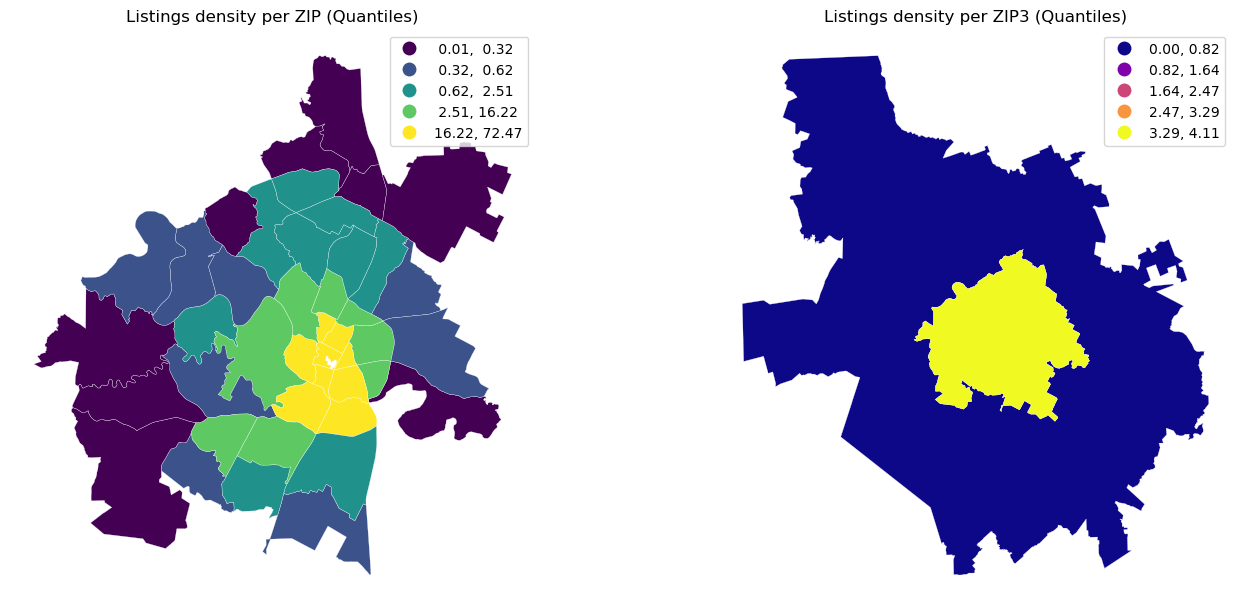

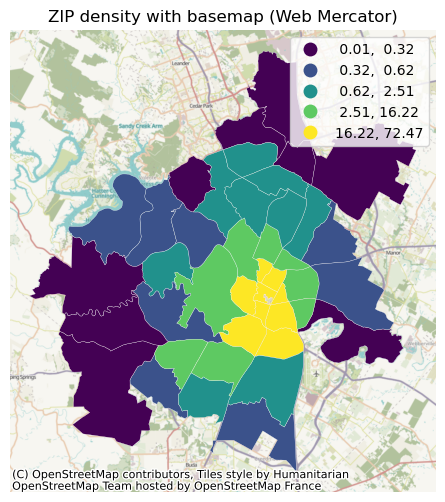

In [201]:
# Choropleths with mapclassify and contextily (optional)
import matplotlib.pyplot as plt

# Merge stats back to polygons for plotting
zip_plot = tx_zip_aea.merge(zip_stats[[zip_col, 'density_per_km2']], on=zip_col, how='left')

fig, axes = plt.subplots(1, 2, figsize=(14,6), constrained_layout=True)
zip_plot.plot(column='density_per_km2', scheme='Quantiles', k=5, cmap='viridis', legend=True, ax=axes[0], edgecolor='white', linewidth=0.2)
axes[0].set_title('Listings density per ZIP (Quantiles)')

# ZIP3 choropleth requires geometry; use dissolved polygons
zip3_plot = zip3_poly.merge(zip3_stats[['ZIP3','density_per_km2']], on='ZIP3', how='left')
zip3_plot.plot(column='density_per_km2', scheme='Quantiles', k=5, cmap='plasma', legend=True, ax=axes[1], edgecolor='white', linewidth=0.2)
axes[1].set_title('Listings density per ZIP3 (Quantiles)')

for ax in axes:
    ax.axis('off')
plt.show()

# Optional: add contextily basemap (project to 3857)
try:
    import contextily as cx
    zip_plot_3857 = zip_plot.to_crs(3857)
    ax = zip_plot_3857.plot(column='density_per_km2', scheme='Quantiles', k=5, cmap='viridis', legend=True, figsize=(8,6), edgecolor='white', linewidth=0.2)
    cx.add_basemap(ax, crs=zip_plot_3857.crs)
    ax.set_title('ZIP density with basemap (Web Mercator)')
    ax.axis('off')
    plt.show()
except Exception as e:
    print('Basemap skipped:', e)
